## Setup

In [1]:
GLOBAL_SEED = 42

import os
os.environ['PYTHONHASHSEED'] = str(GLOBAL_SEED)
import glob
import sys
import shutil
import pickle
import random as rnd
from tqdm import tqdm

import numpy as np
from numpy import random as np_rnd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression as lm
from scipy.stats import f_oneway

import librosa

import torch
from torch import nn
from torch.nn import functional as F

from matplotlib import rc, rcParams
import matplotlib.font_manager as fm
rc('font', family=fm.FontProperties(fname='./font/NanumSquareR.ttf').get_name())
rcParams['axes.unicode_minus'] = False

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # python random
    rnd.seed(seed)
    # numpy random
    np_rnd.seed(seed)
    # tf random
    try:
        tf_rnd.set_seed(seed)
    except:
        pass
    # RAPIDS random
    try:
        cupy.random.seed(seed)
    except:
        pass
    # pytorch random
    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    except:
        pass

def pickleIO(obj, src, op="w"):
    if op == "w":
        with open(src, op + "b") as f:
            pickle.dump(obj, f)
    elif op == "r":
        with open(src, op + "b") as f:
            tmp = pickle.load(f)
        return tmp
    else:
        print("unknown operation")
        return obj
    
def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)
        
def week_of_month(dt):
    """ 
        Returns the week of the month for the specified date.
    """
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + (1 + first_day.weekday()) % 7
    return int(np.ceil(adjusted_dom/7.0))

def get_season(dt):
    dt = int(dt)
    if dt in [3, 4, 5]:
        return "봄"
    elif dt in [6, 7, 8]:
        return "여름"
    elif dt in [9, 10, 11]:
        return "가을"
    else:
        return "겨울"

In [3]:
class CFG:
    debug = True
    data_path = ".\\data\\"
    
    n_mfcc = 32
    n_chroma = 16

## Loading data

In [4]:
# Save datasets
df = pickleIO(None, "./dataset/df.pkl", "r")

In [5]:
df

,data_path,type,timestamp,zcr,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,rms_0,rms_1,rms_2,rms_3,rms_4,rms_5,month,season,temp,hum
1768,.\data\dry\dry_202211\train_dry_06487.wav,dry,2022-11-01,0.066251,-111.678139,143.989548,-16.020607,15.938121,-14.988107,9.656831,...,0.101871,0.010458,0.117470,0.071039,0.046431,0.653595,11,2,12.853333,55.112222
1533,.\data\dry\dry_202210\train_dry_05993.wav,dry,2022-10-01,0.076482,-82.334991,127.646667,-21.958435,23.165316,-15.338418,2.577787,...,0.122161,0.016710,0.147781,0.066668,0.081113,1.216681,10,2,20.590323,64.034409
8613,.\data\abdominal\abdominal_202210\train_abdomi...,abdominal,2022-10-01,0.118658,-182.855850,132.095963,-57.176624,21.259148,-6.309916,9.180972,...,0.036870,0.012043,0.053808,0.015559,0.038249,2.458286,10,2,20.590323,64.034409
12193,.\data\abdominal\abdominal_202301\train_abdomi...,abdominal,2023-01-01,0.082634,-157.992645,137.026566,-28.493830,17.210140,-17.940218,3.368594,...,0.050445,0.007264,0.058700,0.032006,0.026694,0.834033,1,3,4.069892,48.419355
13786,.\data\abdominal\abdominal_202302\train_abdomi...,abdominal,2023-02-01,0.096142,-123.710777,149.216400,-52.373989,1.302177,-14.321296,7.688919,...,0.096546,0.046163,0.168690,0.025033,0.143657,5.738713,2,3,7.042693,51.873399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13418,.\data\abdominal\abdominal_202302\train_abdomi...,abdominal,2023-02-01,0.124320,-153.296249,132.146774,-71.687675,2.211246,-14.678252,7.649873,...,0.072325,0.044000,0.144398,0.010505,0.133893,12.745489,2,3,7.042693,51.873399
5390,.\data\abdominal\abdominal_202208\train_abdomi...,abdominal,2022-08-01,0.114414,-202.418961,128.363342,-49.688839,2.319815,-18.161375,20.569262,...,0.029962,0.009042,0.042852,0.015383,0.027469,1.785730,8,1,30.219355,80.798925
860,.\data\dry\dry_202209\train_dry_03576.wav,dry,2022-09-01,0.105301,-124.914452,117.577019,-24.796532,23.039095,-11.142825,11.782237,...,0.058520,0.006055,0.068395,0.043174,0.025221,0.584170,9,2,26.532222,78.021111
15795,.\data\abdominal\abdominal_202303\train_abdomi...,abdominal,2023-03-01,0.102876,-176.967087,122.279282,-43.179363,8.484152,-1.341574,4.232651,...,0.040267,0.013010,0.060680,0.019540,0.041141,2.105507,3,0,13.506452,58.259140


## Preprocessing

In [6]:
df = df.drop(["data_path", "timestamp"], axis=1)

In [7]:
# df["type"] = df["type"].apply(lambda x: 1 if x == "abdominal" else 0)
df["type"] = df["type"].apply(lambda x: "복식기침" if x == "abdominal" else "건식기침")

In [8]:
# df["month"] = df["month"] - 1

In [9]:
# ohe_cols = []
# for i, j in zip(["month", "season"], [list(range(12)), list(range(4))]):
#     ohe_cols.extend([i + "_ohe_" + str(z) for z in j])

# ohe = OneHotEncoder(categories=[list(range(12)), list(range(4))], sparse=False)
# df[ohe_cols] = pd.DataFrame(ohe.fit_transform(df[["month", "season"]]), columns=ohe_cols)
# df = df.drop(["month", "season"], axis=1)

In [10]:
df.groupby(["season", "month"]).size()

season  month
0       3        1999
1       8        1993
2       9        1996
        10       2000
        11       1996
3       1        1995
        2        2000
        12       1999
dtype: int64

In [11]:
df["season"] = df["month"].apply(get_season)

In [12]:
df

,type,zcr,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,rms_0,rms_1,rms_2,rms_3,rms_4,rms_5,month,season,temp,hum
1768,건식기침,0.066251,-111.678139,143.989548,-16.020607,15.938121,-14.988107,9.656831,-9.725499,-4.146101,...,0.101871,0.010458,0.117470,0.071039,0.046431,0.653595,11,가을,12.853333,55.112222
1533,건식기침,0.076482,-82.334991,127.646667,-21.958435,23.165316,-15.338418,2.577787,-12.986725,2.719866,...,0.122161,0.016710,0.147781,0.066668,0.081113,1.216681,10,가을,20.590323,64.034409
8613,복식기침,0.118658,-182.855850,132.095963,-57.176624,21.259148,-6.309916,9.180972,-4.086691,3.312847,...,0.036870,0.012043,0.053808,0.015559,0.038249,2.458286,10,가을,20.590323,64.034409
12193,복식기침,0.082634,-157.992645,137.026566,-28.493830,17.210140,-17.940218,3.368594,-4.121663,0.544858,...,0.050445,0.007264,0.058700,0.032006,0.026694,0.834033,1,겨울,4.069892,48.419355
13786,복식기침,0.096142,-123.710777,149.216400,-52.373989,1.302177,-14.321296,7.688919,-17.740351,-19.338242,...,0.096546,0.046163,0.168690,0.025033,0.143657,5.738713,2,겨울,7.042693,51.873399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13418,복식기침,0.124320,-153.296249,132.146774,-71.687675,2.211246,-14.678252,7.649873,-9.934976,-14.064836,...,0.072325,0.044000,0.144398,0.010505,0.133893,12.745489,2,겨울,7.042693,51.873399
5390,복식기침,0.114414,-202.418961,128.363342,-49.688839,2.319815,-18.161375,20.569262,-14.804974,-14.106078,...,0.029962,0.009042,0.042852,0.015383,0.027469,1.785730,8,여름,30.219355,80.798925
860,건식기침,0.105301,-124.914452,117.577019,-24.796532,23.039095,-11.142825,11.782237,-10.009353,-4.233706,...,0.058520,0.006055,0.068395,0.043174,0.025221,0.584170,9,가을,26.532222,78.021111
15795,복식기침,0.102876,-176.967087,122.279282,-43.179363,8.484152,-1.341574,4.232651,-17.113363,-8.872327,...,0.040267,0.013010,0.060680,0.019540,0.041141,2.105507,3,봄,13.506452,58.259140


## EDA

### TL;DR
* MFCC feature is significant
* Chorma Frequencies feature is significant
* On MFCC & Chorma, as **lower mean and higher std Type 1 is more than Type 0**
* RSM feature is significant **but the degree is seems to be less than MFCC, Chorma**
* Temperature & Humidity feature is also significant. As **higher temperature & higher humidity, Type 1 is more than Type 0 (Ex. Summer)**

In [13]:
# target count
df["type"].value_counts(normalize=True)

복식기침    0.67668
건식기침    0.32332
Name: type, dtype: float64

### Date feature

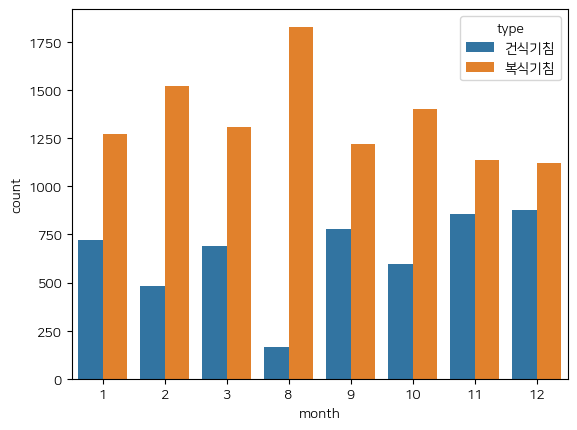

In [14]:
sns.countplot(x=df["month"], hue=df["type"])
plt.show()

In [15]:
df["season"].value_counts(normalize=True)

겨울    0.375141
가을    0.375016
봄     0.125110
여름    0.124734
Name: season, dtype: float64

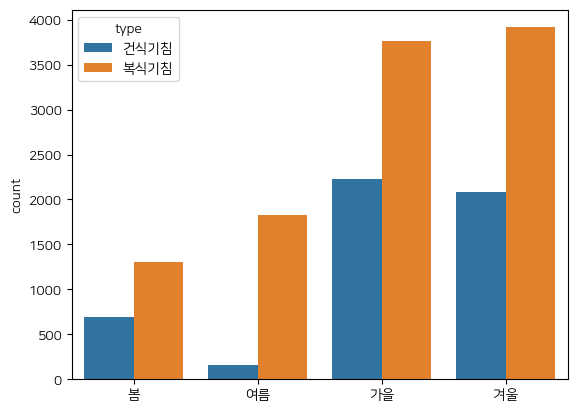

In [16]:
sns.countplot(x=pd.Series(pd.Categorical(df["season"].values, categories=["봄", "여름", "가을", "겨울"], ordered=False), index=df.index), hue=df["type"])
plt.show()

### Note: Summarization
* It shows getting more colds in winter (if the population is same on each months)
* This data shows that abmoninal type is more chance to get in August.

### MFCC feature

In [17]:
df.filter(regex="mfcc")

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_24,mfcc_25,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30,mfcc_31,mfcc_32,mfcc_33
1768,-111.678139,143.989548,-16.020607,15.938121,-14.988107,9.656831,-9.725499,-4.146101,-12.723077,-4.567734,...,-0.718710,1.437323,-4.999427,-2.381844,-5.770948,-0.206560,-5.915168,-1.736567,-2.586348,32.938484
1533,-82.334991,127.646667,-21.958435,23.165316,-15.338418,2.577787,-12.986725,2.719866,-11.892662,-8.395316,...,0.688019,-0.039456,-4.465788,-0.970777,-5.326400,-0.093266,-3.176230,-1.241228,-2.308483,28.097122
8613,-182.855850,132.095963,-57.176624,21.259148,-6.309916,9.180972,-4.086691,3.312847,-16.089405,-11.028007,...,-0.242104,-0.745419,-4.558949,4.889170,-3.284075,1.197382,-3.255645,-3.077676,-4.819380,41.426292
12193,-157.992645,137.026566,-28.493830,17.210140,-17.940218,3.368594,-4.121663,0.544858,-11.795541,-3.702428,...,-3.189021,-1.585489,-4.624955,-2.804006,-5.388624,-1.343891,-4.515184,0.397142,-4.374107,37.650982
13786,-123.710777,149.216400,-52.373989,1.302177,-14.321296,7.688919,-17.740351,-19.338242,-10.708569,-0.963094,...,-2.679104,0.025930,-4.370794,2.159896,-3.680580,-1.224486,-5.015295,4.132817,-3.950735,36.009464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13418,-153.296249,132.146774,-71.687675,2.211246,-14.678252,7.649873,-9.934976,-14.064836,-3.972687,-13.574855,...,-2.077366,-2.138381,-0.280596,0.717813,-5.351163,1.684956,-5.066197,-5.530992,-5.379477,38.209942
5390,-202.418961,128.363342,-49.688839,2.319815,-18.161375,20.569262,-14.804974,-14.106078,-12.046690,-2.270313,...,-5.079259,0.451102,-0.644006,1.036557,-4.539334,-1.177877,-3.427816,7.594135,-6.031336,43.456516
860,-124.914452,117.577019,-24.796532,23.039095,-11.142825,11.782237,-10.009353,-4.233706,-13.846220,-1.836921,...,-2.838268,0.310399,-1.944835,-1.339231,-2.766194,1.963493,-3.418240,2.041409,-3.261018,31.266506
15795,-176.967087,122.279282,-43.179363,8.484152,-1.341574,4.232651,-17.113363,-8.872327,-20.376759,-0.815930,...,0.236045,4.807001,3.154400,2.568170,-9.231818,-2.223933,-6.498464,-3.542521,-5.834164,38.893276


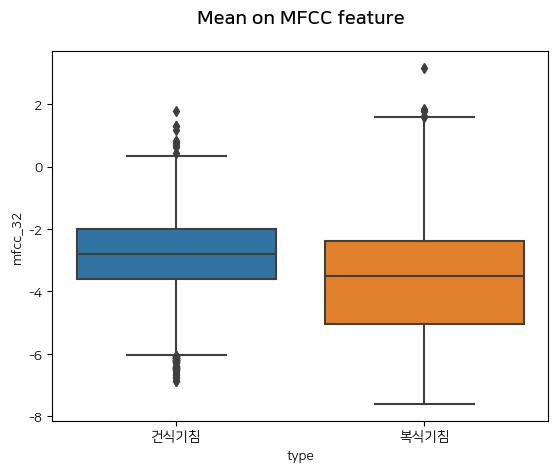

In [18]:
sns.boxplot(x=df["type"], y=df["mfcc_32"])
plt.title("Mean on MFCC feature", fontweight="bold", fontsize=14, pad=20)
plt.show()

In [19]:
# ANOVA
result = f_oneway(df.loc[df["type"]=="복식기침", "mfcc_32"].values, df.loc[df["type"]=="건식기침", "mfcc_32"].values)
result

F_onewayResult(statistic=966.1277411100974, pvalue=5.351997105319305e-206)

In [20]:
if result[1] < 0.05:
    print(f"Mean of two groups are different !")
else:
    print("Mean of two groups are hard to say diffrent")

Mean of two groups are different !


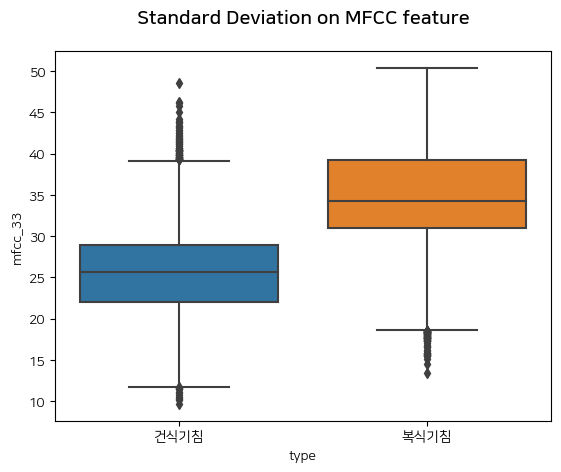

In [21]:
sns.boxplot(x=df["type"], y=df["mfcc_33"])
plt.title("Standard Deviation on MFCC feature", fontweight="bold", fontsize=14, pad=20)
plt.show()

In [22]:
# ANOVA
result = f_oneway(df.loc[df["type"]=="복식기침", "mfcc_33"].values, df.loc[df["type"]=="건식기침", "mfcc_33"].values)
result

F_onewayResult(statistic=7988.000183825692, pvalue=0.0)

In [23]:
if result[1] < 0.05:
    print(f"Mean of two groups are different !")
else:
    print("Mean of two groups are hard to say diffrent")

Mean of two groups are different !


### Note: Summarization
* The averages of MFCC embedding vector on each groups are statistically significantly different
* The standard deviations of MFCC embedding vector on each groups are statistically significantly different

### Chorma Frequencies Feature

In [24]:
df.filter(regex="cf")

,cf_0,cf_1,cf_2,cf_3,cf_4,cf_5,cf_6,cf_7,cf_8,cf_9,cf_10,cf_11,cf_12,cf_13,cf_14,cf_15,cf_16,cf_17
1768,0.273162,0.333239,0.558199,0.664546,0.698749,0.653366,0.615175,0.385752,0.293762,0.276329,0.268257,0.345260,0.324188,0.267691,0.256264,0.307409,0.407584,0.160858
1533,0.266052,0.337636,0.480931,0.562953,0.495797,0.439168,0.808274,0.645578,0.251537,0.199443,0.185237,0.229945,0.320180,0.303052,0.273225,0.270380,0.379337,0.171712
8613,0.473722,0.792079,0.484915,0.663869,0.755631,0.489285,0.361832,0.445570,0.570311,0.421920,0.293300,0.221000,0.190497,0.234305,0.296405,0.336996,0.439477,0.178186
12193,0.412388,0.609363,0.570212,0.728619,0.844355,0.727476,0.663456,0.490740,0.413513,0.469413,0.343079,0.477210,0.660764,0.566598,0.469630,0.381080,0.551743,0.139200
13786,0.529076,0.521668,0.554925,0.430433,0.705909,0.676607,0.478586,0.411156,0.528396,0.496855,0.521026,0.391305,0.321915,0.359139,0.557658,0.593045,0.504856,0.102270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13418,0.582066,0.630528,0.576427,0.708362,0.614901,0.516324,0.570595,0.676735,0.479887,0.421260,0.382795,0.334727,0.282135,0.313526,0.444525,0.585895,0.507543,0.128003
5390,0.402202,0.353780,0.308301,0.328313,0.367853,0.416082,0.600901,0.910825,0.626273,0.428185,0.360811,0.458413,0.576537,0.586693,0.400407,0.376628,0.468888,0.151217
860,0.478612,0.396629,0.437384,0.389544,0.518929,0.636480,0.494390,0.480059,0.575184,0.615430,0.665567,0.590779,0.611602,0.663352,0.673769,0.655805,0.555220,0.095568
15795,0.426804,0.586714,0.772320,0.777308,0.472979,0.482919,0.530525,0.423798,0.459987,0.364249,0.221868,0.230612,0.260322,0.237669,0.222101,0.325225,0.424712,0.174105


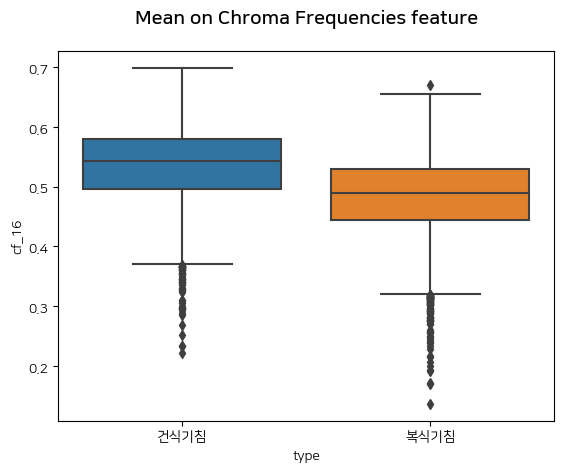

In [25]:
sns.boxplot(x=df["type"], y=df["cf_16"])
plt.title("Mean on Chroma Frequencies feature", fontweight="bold", fontsize=14, pad=20)
plt.show()

In [26]:
# ANOVA
result = f_oneway(df.loc[df["type"]=="복식기침", "cf_16"].values, df.loc[df["type"]=="건식기침", "cf_16"].values)
result

F_onewayResult(statistic=2216.4972299804444, pvalue=0.0)

In [27]:
if result[1] < 0.05:
    print(f"Mean of two groups are different !")
else:
    print("Mean of two groups are hard to say diffrent")

Mean of two groups are different !


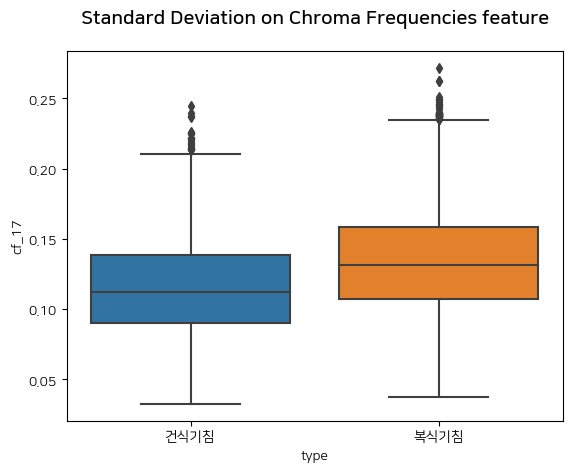

In [28]:
sns.boxplot(x=df["type"], y=df["cf_17"])
plt.title("Standard Deviation on Chroma Frequencies feature", fontweight="bold", fontsize=14, pad=20)
plt.show()

In [29]:
# ANOVA
result = f_oneway(df.loc[df["type"]=="복식기침", "cf_17"].values, df.loc[df["type"]=="건식기침", "cf_17"].values)
result

F_onewayResult(statistic=918.0670355785809, pvalue=3.92700310256283e-196)

In [30]:
if result[1] < 0.05:
    print(f"Mean of two groups are different !")
else:
    print("Mean of two groups are hard to say diffrent")

Mean of two groups are different !


### Note: Summarization
* The averages of Chorma Frequencies embedding vector on each groups are statistically significantly different
* The standard deviations of Chorma Frequencies embedding vector on each groups are statistically significantly different

### RMS Feature

In [31]:
df.filter(regex="rms")
# mean, std, max, min, min-max range, min-max percentage change

,rms_0,rms_1,rms_2,rms_3,rms_4,rms_5
1768,0.101871,0.010458,0.117470,0.071039,0.046431,0.653595
1533,0.122161,0.016710,0.147781,0.066668,0.081113,1.216681
8613,0.036870,0.012043,0.053808,0.015559,0.038249,2.458286
12193,0.050445,0.007264,0.058700,0.032006,0.026694,0.834033
13786,0.096546,0.046163,0.168690,0.025033,0.143657,5.738713
...,...,...,...,...,...,...
13418,0.072325,0.044000,0.144398,0.010505,0.133893,12.745489
5390,0.029962,0.009042,0.042852,0.015383,0.027469,1.785730
860,0.058520,0.006055,0.068395,0.043174,0.025221,0.584170
15795,0.040267,0.013010,0.060680,0.019540,0.041141,2.105507


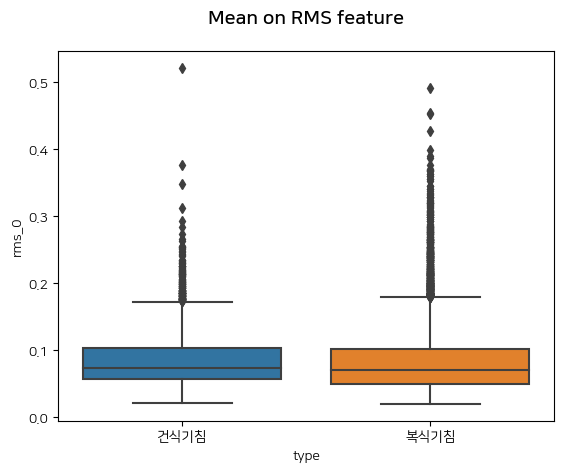

In [32]:
sns.boxplot(x=df["type"], y=df["rms_0"])
plt.title("Mean on RMS feature", fontweight="bold", fontsize=14, pad=20)
plt.show()

In [33]:
# ANOVA
result = f_oneway(df.loc[df["type"]=="복식기침", "rms_0"].values, df.loc[df["type"]=="건식기침", "rms_0"].values)
result

F_onewayResult(statistic=0.04040441797894915, pvalue=0.840694484802333)

In [34]:
if result[1] < 0.05:
    print(f"Mean of two groups are different !")
else:
    print("Mean of two groups are hard to say diffrent")

Mean of two groups are hard to say diffrent


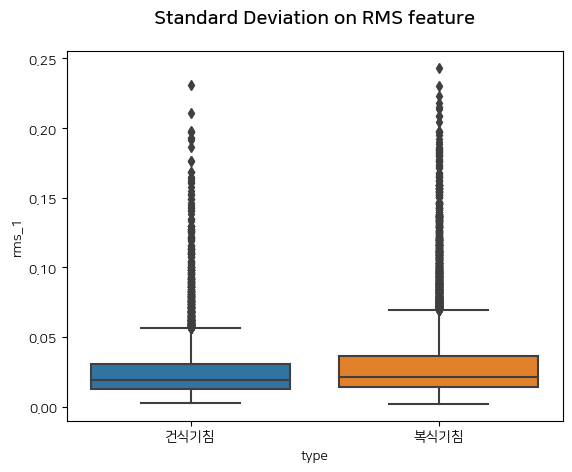

In [35]:
sns.boxplot(x=df["type"], y=df["rms_1"])
plt.title("Standard Deviation on RMS feature", fontweight="bold", fontsize=14, pad=20)
plt.show()

In [36]:
# ANOVA
result = f_oneway(df.loc[df["type"]=="복식기침", "rms_1"].values, df.loc[df["type"]=="건식기침", "rms_1"].values)
result

F_onewayResult(statistic=104.04119678821635, pvalue=2.3531512355495256e-24)

In [37]:
if result[1] < 0.05:
    print(f"Mean of two groups are different !")
else:
    print("Mean of two groups are hard to say diffrent")

Mean of two groups are different !


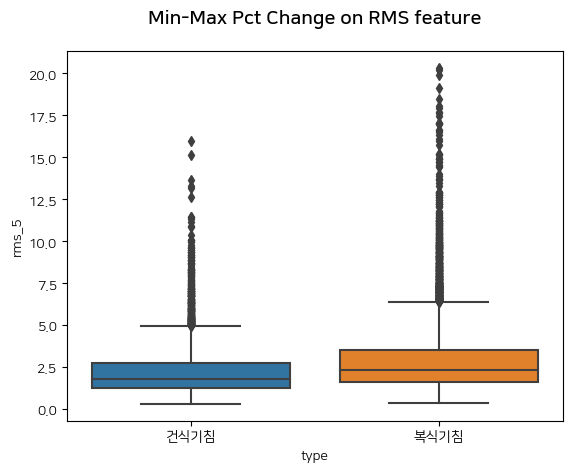

In [38]:
sns.boxplot(x=df["type"], y=df["rms_5"])
plt.title("Min-Max Pct Change on RMS feature", fontweight="bold", fontsize=14, pad=20)
plt.show()

In [39]:
# ANOVA
result = f_oneway(df.loc[df["type"]=="복식기침", "rms_5"].values, df.loc[df["type"]=="건식기침", "rms_5"].values)
result

F_onewayResult(statistic=434.0002961616152, pvalue=4.012396869103822e-95)

In [40]:
if result[1] < 0.05:
    print(f"Mean of two groups are different !")
else:
    print("Mean of two groups are hard to say diffrent")

Mean of two groups are different !


### Note: Summarization
* The averages of Chorma Frequencies embedding vector on each groups are **hard to say statistically significantly different**
* The standard deviations of Chorma Frequencies embedding vector on each groups are statistically significantly different
* The percentage changes of Chorma Frequencies embedding vector on each groups are statistically significantly different

### Climate feature

In [41]:
df[["temp", "hum"]]

,temp,hum
1768,12.853333,55.112222
1533,20.590323,64.034409
8613,20.590323,64.034409
12193,4.069892,48.419355
13786,7.042693,51.873399
...,...,...
13418,7.042693,51.873399
5390,30.219355,80.798925
860,26.532222,78.021111
15795,13.506452,58.259140


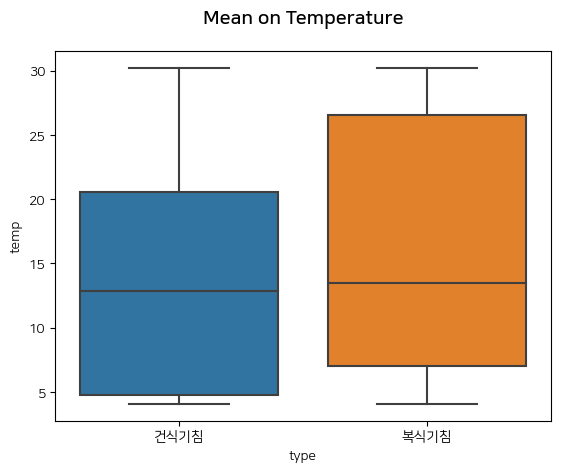

In [42]:
sns.boxplot(x=df["type"], y=df["temp"])
plt.title("Mean on Temperature", fontweight="bold", fontsize=14, pad=20)
plt.show()

In [43]:
# ANOVA
result = f_oneway(df.loc[df["type"]=="복식기침", "temp"].values, df.loc[df["type"]=="건식기침", "temp"].values)
result

F_onewayResult(statistic=241.69500007635247, pvalue=4.1823555692675833e-54)

In [44]:
if result[1] < 0.05:
    print(f"Mean of two groups are different !")
else:
    print("Mean of two groups are hard to say diffrent")

Mean of two groups are different !


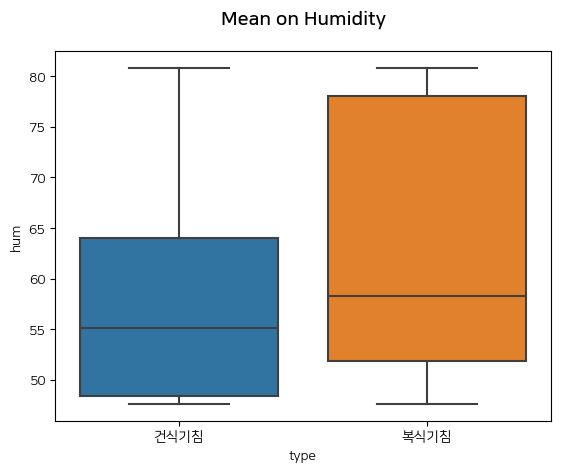

In [45]:
sns.boxplot(x=df["type"], y=df["hum"])
plt.title("Mean on Humidity", fontweight="bold", fontsize=14, pad=20)
plt.show()

In [46]:
# ANOVA
result = f_oneway(df.loc[df["type"]=="복식기침", "hum"].values, df.loc[df["type"]=="건식기침", "hum"].values)
result

F_onewayResult(statistic=259.75699376335115, pvalue=5.5542457277570805e-58)

In [47]:
if result[1] < 0.05:
    print(f"Mean of two groups are different !")
else:
    print("Mean of two groups are hard to say diffrent")

Mean of two groups are different !


### Note: Summarization
* The averages of temperature (Seoul highest) on each groups are statistically significantly different
* The averages of humidity (Busan mean) on each groups are statistically significantly different

## T-SNE Visualization with MFCC & Chorma feature

In [48]:
from sklearn.manifold import TSNE

In [49]:
# MFCC only
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='random', random_state=42)
df_tsne = tsne.fit_transform(df.filter(regex="mfcc").iloc[:, :32])

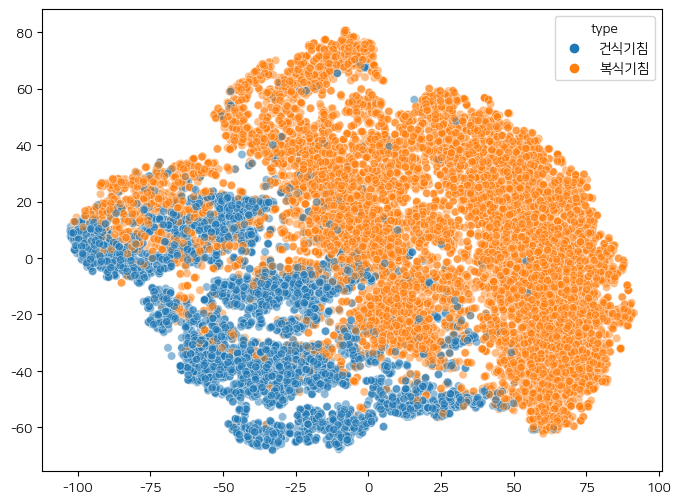

In [50]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1], hue=df["type"], alpha=0.5)
plt.show()

In [51]:
mad0 = np.abs(df_tsne[df["type"] == 0] - df_tsne[df["type"] == 0].mean(axis=0)).sum(axis=0).mean()
mad1 = np.abs(df_tsne[df["type"] == 1] - df_tsne[df["type"] == 1].mean(axis=0)).sum(axis=0).mean()
print("Mean of MAD :", (mad0 / (df["type"] == 0).sum()) + (mad1 / (df["type"] == 1).sum()))

Mean of MAD : nan


C:\Users\flash\AppData\Local\Temp\ipykernel_8364\493081334.py:1: RuntimeWarning: Mean of empty slice.
  mad0 = np.abs(df_tsne[df["type"] == 0] - df_tsne[df["type"] == 0].mean(axis=0)).sum(axis=0).mean()
c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\flash\AppData\Local\Temp\ipykernel_8364\493081334.py:2: RuntimeWarning: Mean of empty slice.
  mad1 = np.abs(df_tsne[df["type"] == 1] - df_tsne[df["type"] == 1].mean(axis=0)).sum(axis=0).mean()
C:\Users\flash\AppData\Local\Temp\ipykernel_8364\493081334.py:3: RuntimeWarning: invalid value encountered in true_divide
  print("Mean of MAD :", (mad0 / (df["type"] == 0).sum()) + (mad1 / (df["type"] == 1).sum()))


In [52]:
# Chroma Frequencies only
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='random', random_state=42)
df_tsne = tsne.fit_transform(df.filter(regex="cf").iloc[:, :16])

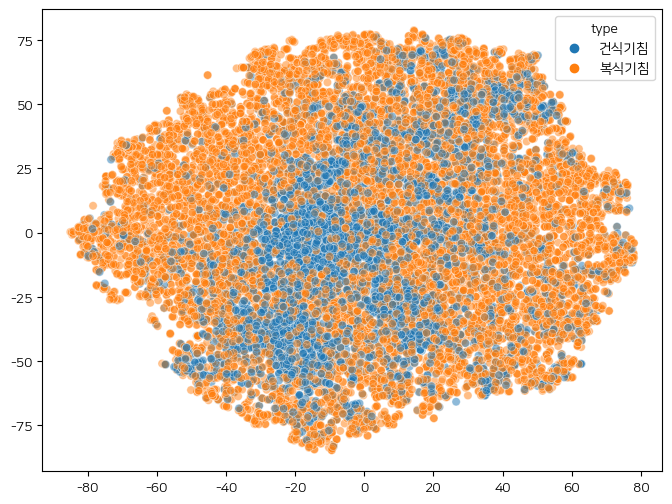

In [53]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1], hue=df["type"], alpha=0.5)
plt.show()

In [54]:
mad0 = np.abs(df_tsne[df["type"] == 0] - df_tsne[df["type"] == 0].mean(axis=0)).sum(axis=0).mean()
mad1 = np.abs(df_tsne[df["type"] == 1] - df_tsne[df["type"] == 1].mean(axis=0)).sum(axis=0).mean()
print("Mean of MAD :", (mad0 / (df["type"] == 0).sum()) + (mad1 / (df["type"] == 1).sum()))

Mean of MAD : nan


C:\Users\flash\AppData\Local\Temp\ipykernel_8364\493081334.py:1: RuntimeWarning: Mean of empty slice.
  mad0 = np.abs(df_tsne[df["type"] == 0] - df_tsne[df["type"] == 0].mean(axis=0)).sum(axis=0).mean()
c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\flash\AppData\Local\Temp\ipykernel_8364\493081334.py:2: RuntimeWarning: Mean of empty slice.
  mad1 = np.abs(df_tsne[df["type"] == 1] - df_tsne[df["type"] == 1].mean(axis=0)).sum(axis=0).mean()
C:\Users\flash\AppData\Local\Temp\ipykernel_8364\493081334.py:3: RuntimeWarning: invalid value encountered in true_divide
  print("Mean of MAD :", (mad0 / (df["type"] == 0).sum()) + (mad1 / (df["type"] == 1).sum()))


In [55]:
# MFCC + Chroma Fequencies
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='random', random_state=42)
df_tsne = tsne.fit_transform(pd.concat([df.filter(regex="mfcc").iloc[:, :32].reset_index(drop=True), df.filter(regex="cf").iloc[:, :16].reset_index(drop=True)], axis=1))

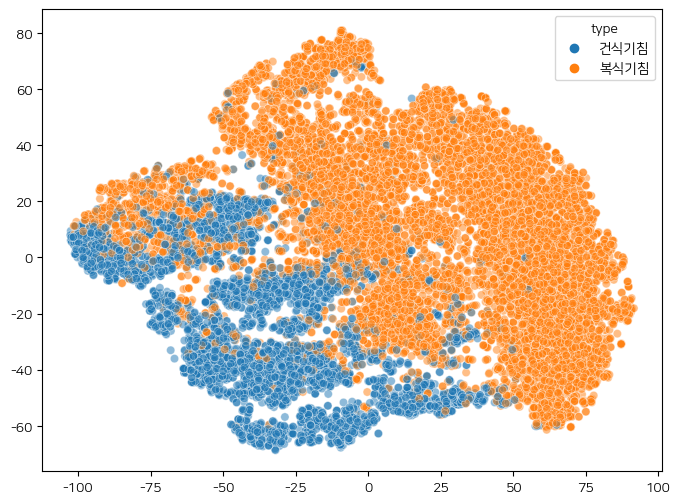

In [56]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1], hue=df["type"], alpha=0.5)
plt.show()

In [57]:
mad0 = np.abs(df_tsne[df["type"] == 0] - df_tsne[df["type"] == 0].mean(axis=0)).sum(axis=0).mean()
mad1 = np.abs(df_tsne[df["type"] == 1] - df_tsne[df["type"] == 1].mean(axis=0)).sum(axis=0).mean()
print("Mean of MAD :", (mad0 / (df["type"] == 0).sum()) + (mad1 / (df["type"] == 1).sum()))

Mean of MAD : nan


C:\Users\flash\AppData\Local\Temp\ipykernel_8364\493081334.py:1: RuntimeWarning: Mean of empty slice.
  mad0 = np.abs(df_tsne[df["type"] == 0] - df_tsne[df["type"] == 0].mean(axis=0)).sum(axis=0).mean()
c:\users\flash\pycharmprojects\smartfarm\venv\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\flash\AppData\Local\Temp\ipykernel_8364\493081334.py:2: RuntimeWarning: Mean of empty slice.
  mad1 = np.abs(df_tsne[df["type"] == 1] - df_tsne[df["type"] == 1].mean(axis=0)).sum(axis=0).mean()
C:\Users\flash\AppData\Local\Temp\ipykernel_8364\493081334.py:3: RuntimeWarning: invalid value encountered in true_divide
  print("Mean of MAD :", (mad0 / (df["type"] == 0).sum()) + (mad1 / (df["type"] == 1).sum()))
